In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd

In [2]:
#Open the data
filename = "sample_2e7_design_precessing_higherordermodes_3detectors.h5"
f = h5py.File(filename)
print(f.keys())

<KeysViewHDF5 ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'det', 'iota', 'mtot', 'psi', 'q', 'ra', 'snr', 'z']>


In [3]:
#Determine downsample
N = int(1e5)

In [4]:
#Create a dataframe with the data
data = {}
for key in f.keys():
    if key != 'snr':
        data[key] = f[key][:N]

data = pd.DataFrame(data)

In [24]:
data

,chi1x,chi1y,chi1z,chi2x,chi2y,chi2z,dec,det,iota,mtot,psi,q,ra,z
0,-0.307201,0.276165,-0.430760,-0.161114,-0.092334,-0.414647,-0.329671,0,1.809310,906.803562,1.286031,0.624780,-3.116784,2.139659
1,-0.734712,-0.498493,-0.298162,0.057532,-0.844992,0.014708,0.526740,0,0.820820,59.102112,0.934308,0.986650,1.360291,2.438707
2,-0.057831,-0.703796,-0.354512,-0.215538,0.016323,0.130543,0.315799,0,2.008206,44.602750,1.535520,0.286199,0.079973,1.869461
3,0.015260,-0.202467,-0.492768,-0.237033,-0.365363,-0.876192,0.432105,0,2.018398,534.378032,3.064086,0.538882,-1.780558,0.428061
4,-0.016731,0.007848,0.005007,0.147519,0.231879,0.086716,-0.458711,1,2.037363,573.821705,0.752211,0.846310,2.789289,0.772609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-0.710484,0.203788,-0.030539,-0.194861,0.014570,-0.054834,-0.239913,0,1.905192,326.220322,1.473113,0.802986,1.273264,1.901201
99996,0.804222,0.086352,0.550408,0.181968,0.824057,0.412858,0.195437,0,1.920145,403.949547,0.184597,0.386258,-1.279446,1.491419
99997,0.652722,-0.022264,0.132145,0.272847,0.381442,0.773596,-0.584279,1,2.637491,884.399749,1.601521,0.722733,0.444194,0.735589
99998,-0.134977,0.016409,-0.207572,-0.100090,0.117877,0.054799,0.754165,1,1.147342,949.832616,0.060168,0.459489,-0.415330,0.394833


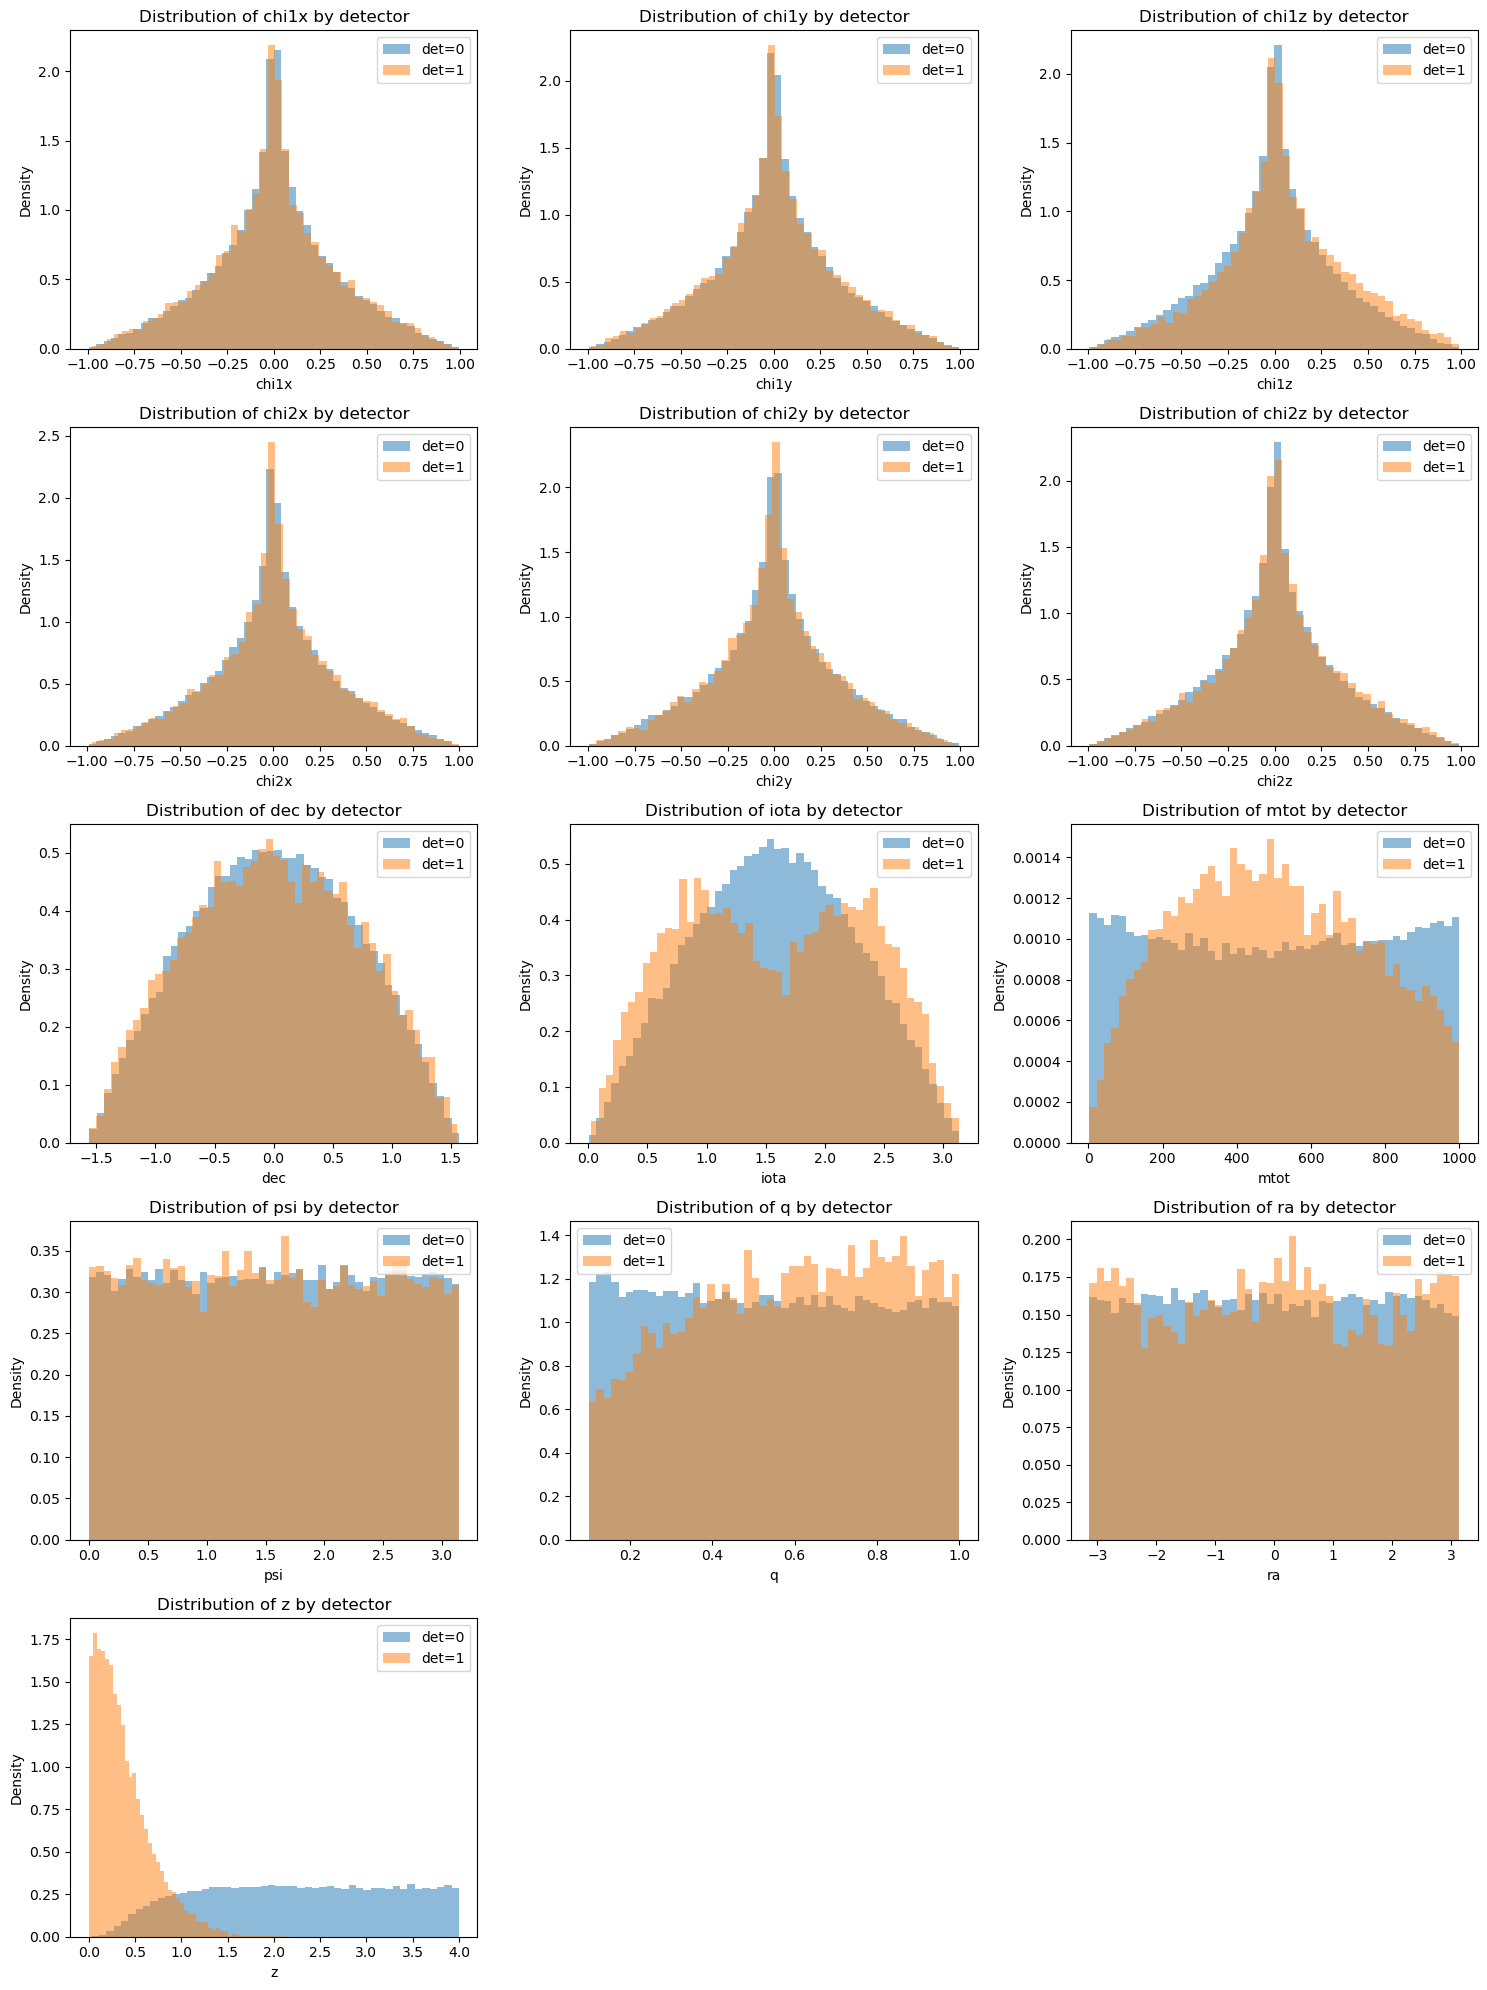

In [6]:
#Plot the features in histograms to see their distributions accordingly to 'det' as subplots
features = list(data.columns)
features.remove('det')
n_features = len(features)
n_cols = 3
n_rows = int(np.ceil(n_features / n_cols))
plt.figure(figsize=(5*n_cols, 4*n_rows))
for i, feature in enumerate(features):
    plt.subplot(n_rows, n_cols, i+1)
    for det in data['det'].unique():
        subset = data[data['det'] == det]
        plt.hist(subset[feature], bins=50, alpha=0.5, label=f'det={det}', density=True)
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.title(f'Distribution of {feature} by detector')
    plt.legend()
plt.tight_layout()
plt.show()

Some features aren't really helpful to discern the detection → let's use only iota, mtot, q, ra and z

In [5]:
#Prepare the data for ML
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(data[['mtot', 'q', 'ra', 'iota', 'z']].values)
y = data['det'].values

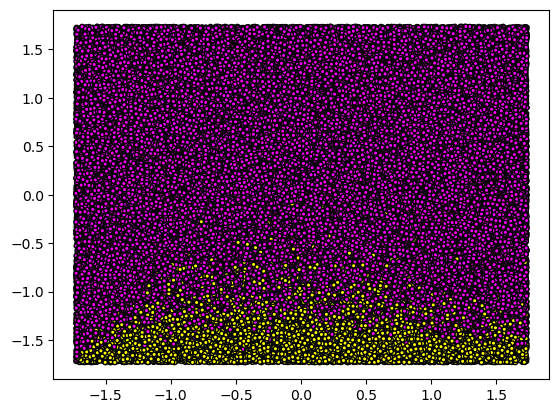

In [6]:
#Quick plot of mtot vs z
plt.scatter(X[:, 0], X[:, 4], c=y, s=10, 
            cmap='spring',edgecolor='k')

ATTENTION!

↓ It takes a lot of time → Best parameter is 17

In [ ]:
#Perform a CV with randomforest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=0, criterion='entropy', n_jobs=-1) #n_estimators=100
drange = np.arange(1,20)

grid = GridSearchCV(rf, param_grid={'max_depth': drange}, cv=5, n_jobs=-1, verbose=1) 
grid.fit(X, y)

best = grid.best_params_['max_depth']
print("best parameter choice:", best)

#rf = grid.best_estimator_ 

Fitting 5 folds for each of 19 candidates, totalling 95 fits


/home/morgan/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


best parameter choice: 17


In [7]:
#Service cell if you don't want to run the gridsearch again
from sklearn.ensemble import RandomForestClassifier
best = 17
rf = RandomForestClassifier(random_state=0, max_depth=best, criterion='entropy', n_jobs=-1)

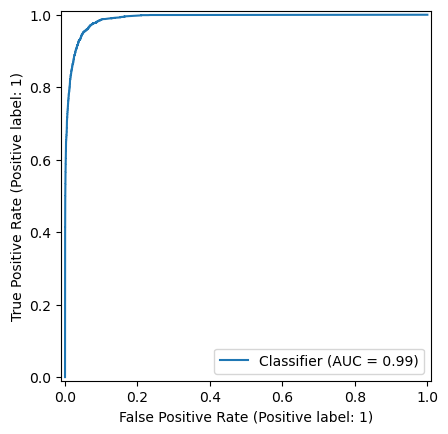

In [8]:
#Plot the ROC curve for the best model
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test = scaler.fit_transform(X_train), scaler.transform(X_test)
rf.fit(X_train, y_train)
y_score = rf.predict_proba(X_test)[:, 1]
RocCurveDisplay.from_predictions(y_test, y_score)
plt.show()

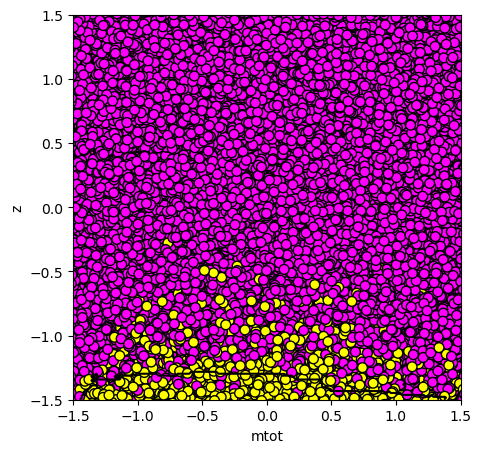

In [11]:
#Plot the decision boundary for mtot vs z
#Bounds for plotting
xlim = (-1.5, 1.5)
ylim = (-1.5, 1.5)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 201),
                     np.linspace(ylim[0], ylim[1], 201))

#Build a full feature matrix for the grid
Xgrid = np.zeros((xx.size, X.shape[1]))
Xgrid[:, 0] = xx.ravel()       # first feature
Xgrid[:, 4] = yy.ravel()       # last feature
Xgrid[:, 1:4] = X[:, 1:4].mean(axis=0)   # fill middle features with mean

#Predict on the grid
Z = rf.predict(Xgrid)
Z = Z.reshape(xx.shape)

#----------------------------------------------------------------------
#Plot the results
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

#Scatter data
ax.scatter(X[:, 0], X[:, 4], c=y, s=50, 
           cmap=plt.cm.spring, zorder=2, edgecolor='k')

#Decision boundary (contour line only)
ax.contour(xx, yy, Z, levels=[0.5], colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel("mtot")
ax.set_ylabel("z")
plt.show()

Now let's do it for the whole dataset

In [ ]:
#Create a dictionary with the data → We can't use pandas dataframe for very large datasets
data = {}
for key in f.keys():
    if key != 'snr':
        data[key] = f[key][:]

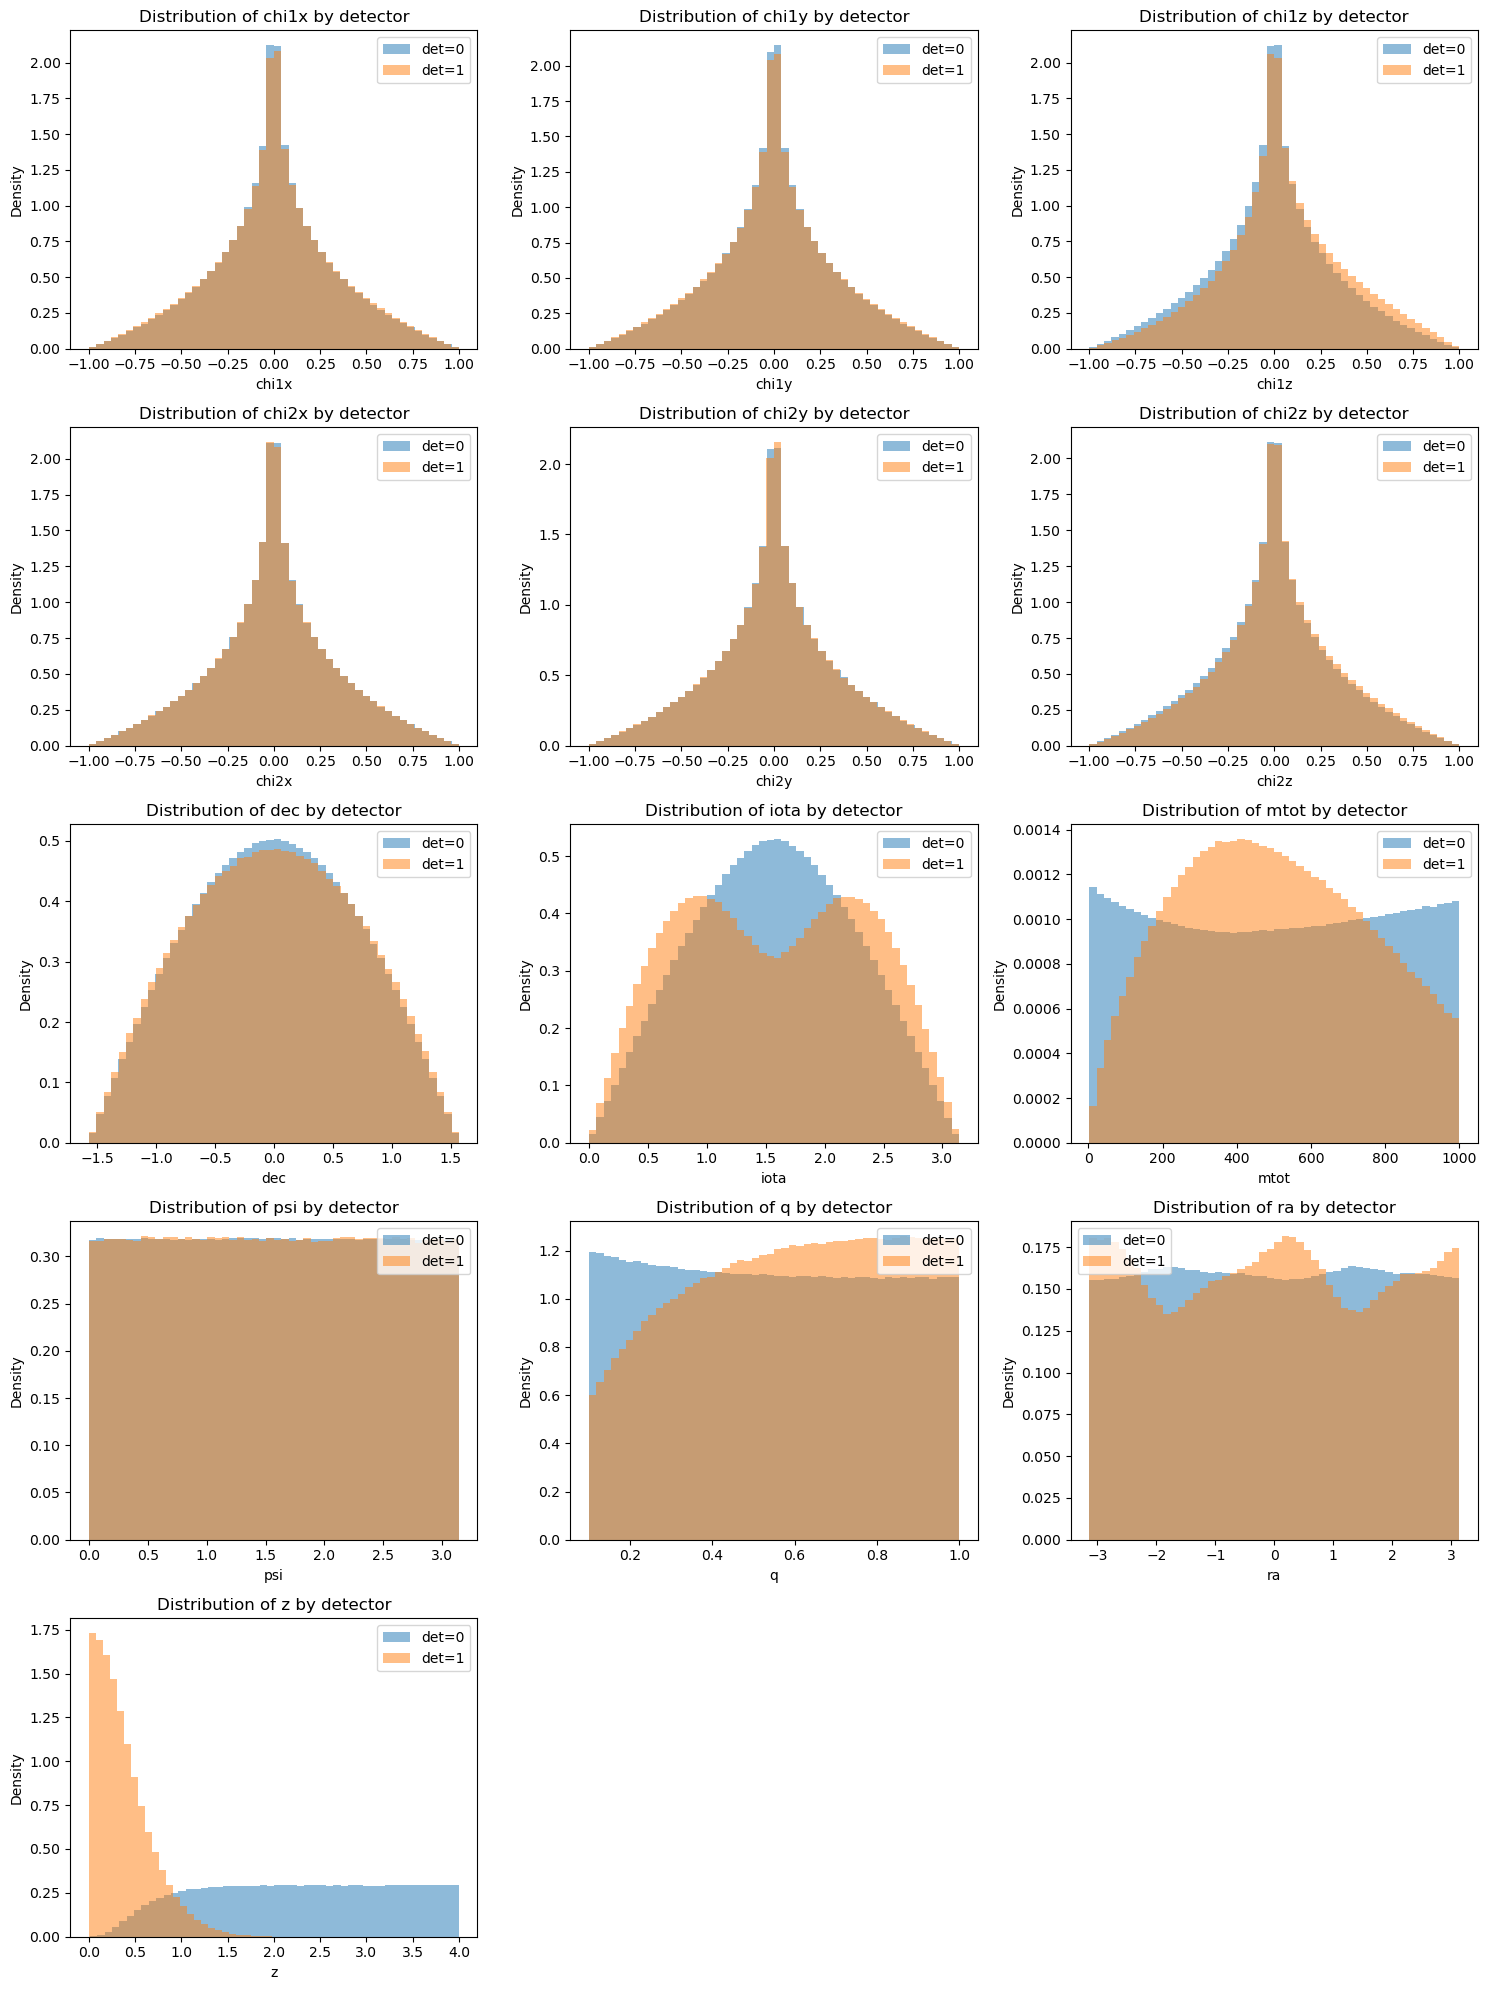

In [13]:
#Plot the features in histograms to see their distributions accordingly to 'det' as subplots
features = list(data.keys())
features.remove('det')
n_features = len(features)
n_cols = 3
n_rows = int(np.ceil(n_features / n_cols))
plt.figure(figsize=(5*n_cols, 4*n_rows))
for i, feature in enumerate(features):
    plt.subplot(n_rows, n_cols, i+1)
    for det in np.unique(data['det']):
        subset = data['det'] == det
        plt.hist(data[feature][subset], bins=50, alpha=0.5, label=f'det={det}', density=True)
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.title(f'Distribution of {feature} by detector')
    plt.legend()
plt.tight_layout()
plt.show()

They maintained shapes similar to the ones of the downsample

Batch: 0


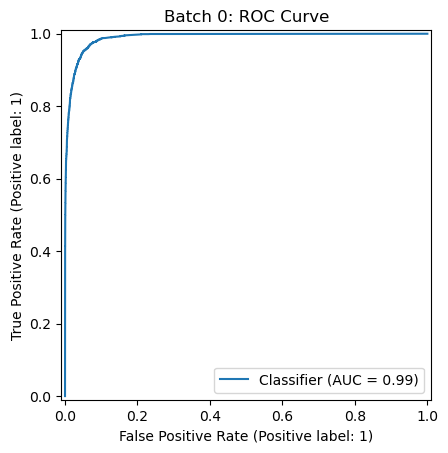

Batch: 1


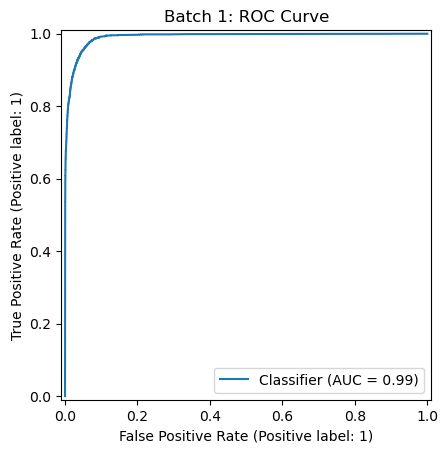

Batch: 2


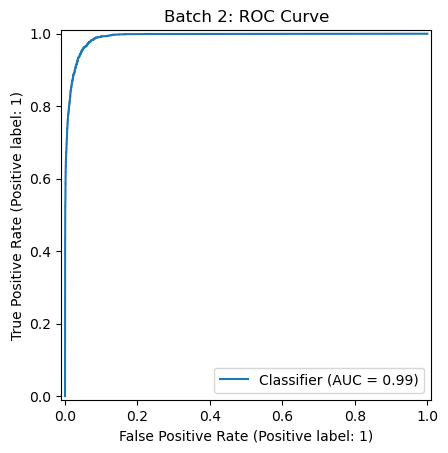

Batch: 3


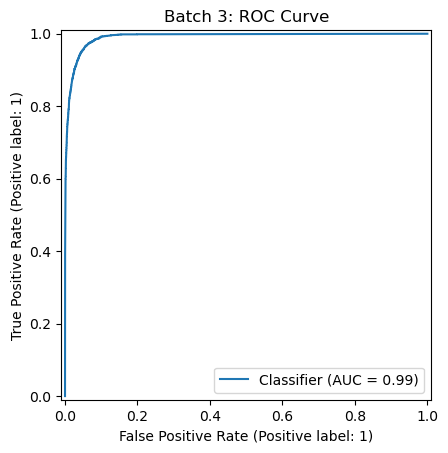

Batch: 4


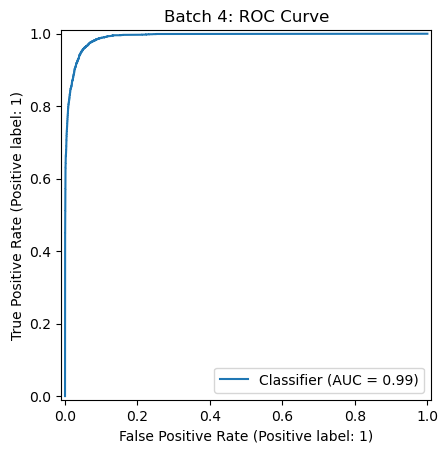

Batch: 5


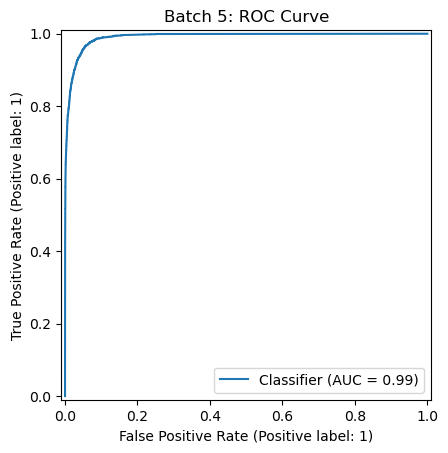

Batch: 6


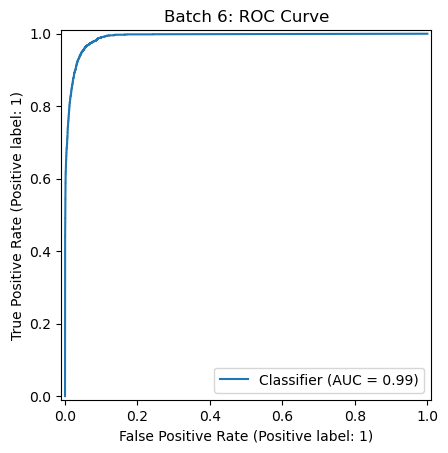

Batch: 7


KeyboardInterrupt: 

In [9]:
#Perform ROC curve with the full dataset
for j in range(int(np.size(f['z'])/N)): #The memoryof of my laptot can't handle all the data at once, so I check if classifier performance is stable across batches
    print("Batch:", j)

    #Prepare the data for ML
    scaler = StandardScaler()
    X = scaler.fit_transform(np.column_stack((f['mtot'][j*N:(j+1)*N], 
                                              f['q'][j*N:(j+1)*N], 
                                              f['ra'][j*N:(j+1)*N], 
                                              f['iota'][j*N:(j+1)*N], 
                                              f['z'][j*N:(j+1)*N])))
    y = f['det'][j*N:(j+1)*N]

    #Plot the ROC curve for the best model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_test = scaler.fit_transform(X_train), scaler.transform(X_test)
    rf.fit(X_train, y_train)
    y_score = rf.predict_proba(X_test)[:, 1]
    RocCurveDisplay.from_predictions(y_test, y_score)
    plt.title(f'Batch {j}: ROC Curve')
    plt.show()
